In [25]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def create_entangled_pair():
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circuit = QuantumCircuit(qr, cr)
    
    circuit.h(qr[0])
    circuit.cx(qr[0], qr[1])
    
    return circuit

def measure_qubit(circuit, qubit, angle):
    circuit.ry(-2 * angle, qubit)
    circuit.measure(qubit, qubit)
    return circuit

def e91_protocol(num_pairs):
    alice_angles = [0, np.pi/8, np.pi/4]
    bob_angles = [0, np.pi/8, -np.pi/8]
    
    results = []
    
    for _ in range(num_pairs):
        circuit = create_entangled_pair()
        
        alice_angle = np.random.choice(alice_angles)
        bob_angle = np.random.choice(bob_angles)
        
        circuit = measure_qubit(circuit, 0, alice_angle)
        circuit = measure_qubit(circuit, 1, bob_angle)
        
        backend = Aer.get_backend('qasm_simulator')
        job = execute(circuit, backend, shots=1)
        result = job.result().get_counts(circuit)
        
        measurement = list(result.keys())[0]
        alice_result = int(measurement[0])
        bob_result = int(measurement[1])
        
        results.append((alice_angle, bob_angle, alice_result, bob_result))
    
    return results

def calculate_correlation(results):
    correlations = {}
    counts = {}
    
    for alice_angle, bob_angle, alice_result, bob_result in results:
        key = (alice_angle, bob_angle)
        if key not in correlations:
            correlations[key] = 0
            counts[key] = 0
        
        correlations[key] += (-1)**(alice_result + bob_result)
        counts[key] += 1
    
    for key in correlations:
        correlations[key] /= counts[key]
    
    return correlations

def calculate_chsh_value(correlations):
    a1, a2 = 0, np.pi/4
    b1, b2 = np.pi/8, -np.pi/8
    
    E = lambda a, b: correlations.get((a, b), 0)
    
    chsh = abs(E(a1, b1) - E(a1, b2) + E(a2, b1) + E(a2, b2))
    
    return chsh

In [27]:
num_pairs = 10000
results = e91_protocol(num_pairs)

In [28]:
# Separate the results for key generation and eavesdropping detection
key_generation_results = [r for r in results if r[0] == r[1]]
eavesdropping_detection_results = [r for r in results if r[0] != r[1]]

In [29]:
key = ''.join([str(r[2]) for r in key_generation_results])
print(f"Generated key (first 20 bits): {key[:20]}...")

Generated key (first 20 bits): 01001110100001001001...


In [30]:
correlations = calculate_correlation(eavesdropping_detection_results)
chsh_value = calculate_chsh_value(correlations)

print(f"Calculated CHSH value: {chsh_value}")
print(f"Is the communication likely secure? {'Yes' if chsh_value > 2 else 'No'}")

Calculated CHSH value: 0.0395245866777596
Is the communication likely secure? No


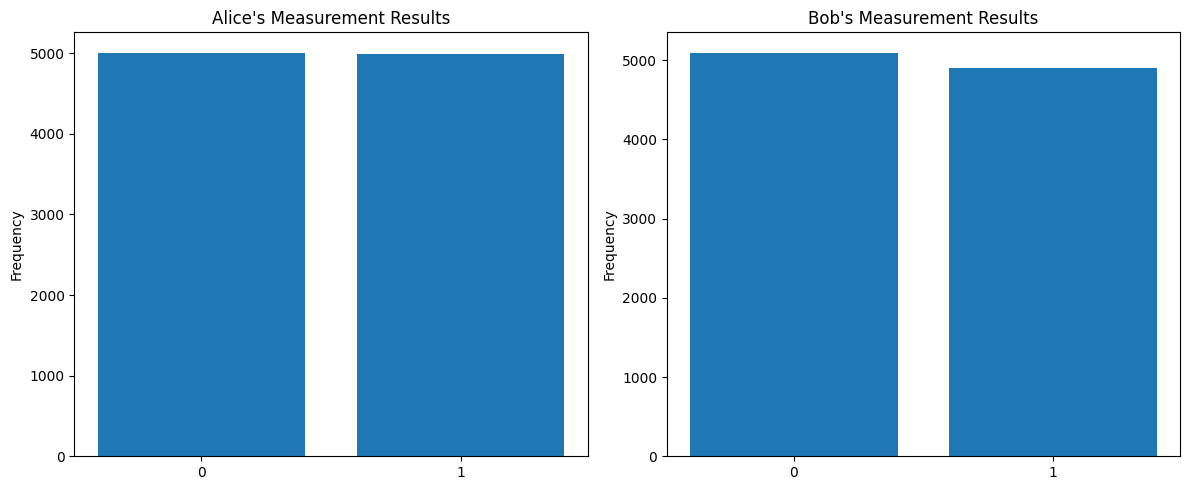

In [31]:
alice_results = [r[2] for r in results]
bob_results = [r[3] for r in results]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(alice_results, bins=[-0.5, 0.5, 1.5], rwidth=0.8)
plt.title("Alice's Measurement Results")
plt.xticks([0, 1])
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(bob_results, bins=[-0.5, 0.5, 1.5], rwidth=0.8)
plt.title("Bob's Measurement Results")
plt.xticks([0, 1])
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

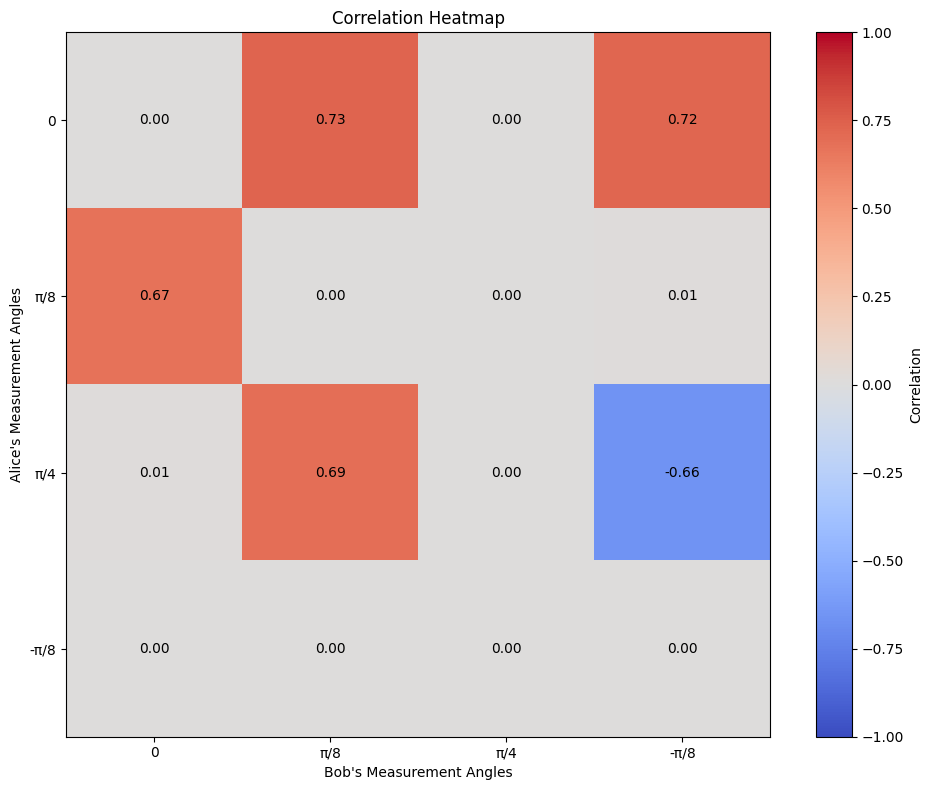

In [32]:
angles = [0, np.pi/8, np.pi/4, -np.pi/8]
correlation_matrix = np.zeros((4, 4))

for i, alice_angle in enumerate(angles):
    for j, bob_angle in enumerate(angles):
        key = (alice_angle, bob_angle)
        correlation_matrix[i, j] = correlations.get(key, 0)

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xlabel("Bob's Measurement Angles")
plt.ylabel("Alice's Measurement Angles")
angle_labels = ['0', 'π/8', 'π/4', '-π/8']
plt.xticks(range(4), angle_labels)
plt.yticks(range(4), angle_labels)

for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()